In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive


 1.1.png
 1.2.png
 1.3.docx
 1.3.gdoc
 1.4.docx
'17. SoDI_Odd Semester End Examination_Dec 2024_14.11.2024.gdoc'
'17. SoDI_Odd Semester End Examination_Dec 2024_14.11.2024.pdf'
 1.htm
 1mean_example.gsheet
'1. Odd Semester_Theory Examination Schedule_December 2024_14.11.2024 (1).gdoc'
'1. Odd Semester_Theory Examination Schedule_December 2024_14.11.2024.gdoc'
'1. Odd Semester_Theory Examination Schedule_December 2024_14.11.2024.pdf'
'1RVU23CSE169_CLOUD LABS - 1,2 & 3.gdoc'
 1RVU23CSE169_Confirmation_Page_for_NPTEL_Course_Enrollment.pdf
 1RVU23CSE169_daa_practicals_5a_2.c.gdoc
'1RVU23CSE169_GOKUL ARVIND VR_HOME ASSIGNMENT1.gdoc'
'1RVU23CSE169_GOKUL ARVIND VR_HOME ASSIGNMENT2.gdoc'
 1RVU23CSE169_GOKUL_ARVIND_VR.logic
 1RVU23CSE169_Gokul_Arvind_VR.png
 1RVU23CSE169_GOKUL_HOMEASSIGNMENT1.gdoc
 1RVU23CSE169_GOKUL_HOMEASSIGNMENT2.gdoc
 1RVU23CSE169_Gokul_Program25.2.gdoc
 1RVU23CSE169_Gokul_Program25.3.gdoc
 1RVU23CSE169_Gokul_Program26.gdoc
 1RVU23CSE169_Gokul_Program27.gdoc
 1RVU23CSE169_G

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/Flickr2K'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extracted to:", extract_path)

Extracted to: /content/Flickr2K


In [ ]:
ls /content/Flickr2K/Flickr2K/

Flickr2K_HR/  Flickr2K_LR_bicubic/  Flickr2K_LR_unknown/


In [ ]:
#!/usr/bin/env python3
# Complete Real-ESRGAN Implementation for Colab
# With all required class definitions

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm



# ======================
# 2. Dataset Handling
# ======================


class DIV2KDataset(Dataset):
    def _init_(self, hr_size=128, scale=4):
        self.hr_path = "/content/Flickr2K/Flickr2K/Flickr2K_HR"
        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def _len_(self): return len(self.image_files)

    def _getitem_(self, idx):
        img = cv2.imread(os.path.join(self.hr_path, self.image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size//self.scale, self.hr_size//self.scale),
                           interpolation=cv2.INTER_CUBIC)
        return {
            'lr': torch.tensor(lr_img/127.5-1).permute(2,0,1).float(),
            'hr': torch.tensor(hr_img/127.5-1).permute(2,0,1).float()
        }

# ======================
# 3. Model Definitions
# ======================
class ResidualDenseBlock(nn.Module):
    def _init_(self, nf=64, gc=32):
        super()._init_()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1)
        self.conv2 = nn.Conv2d(nf+gc, gc, 3, 1, 1)
        self.conv3 = nn.Conv2d(nf+2*gc, gc, 3, 1, 1)
        self.conv4 = nn.Conv2d(nf+3*gc, gc, 3, 1, 1)
        self.conv5 = nn.Conv2d(nf+4*gc, nf, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        return x5 * 0.2 + x

class RRDB(nn.Module):
    def _init_(self, nf=64, gc=32):
        super()._init_()
        self.rdb1 = ResidualDenseBlock(nf, gc)
        self.rdb2 = ResidualDenseBlock(nf, gc)
        self.rdb3 = ResidualDenseBlock(nf, gc)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return out * 0.2 + x

class ESRGANGenerator(nn.Module):
    def _init_(self, in_nc=3, out_nc=3, nf=64, nb=23, gc=32, scale=4):
        super()._init_()
        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1)
        self.body = nn.ModuleList([RRDB(nf, gc) for _ in range(nb)])
        self.conv_body = nn.Conv2d(nf, nf, 3, 1, 1)

        self.upsample = nn.Sequential(
            nn.Conv2d(nf, nf*4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf*4, 3, 1, 1) if scale == 4 else nn.Identity(),
            nn.PixelShuffle(2) if scale == 4 else nn.Identity(),
            nn.LeakyReLU(0.2, True) if scale == 4 else nn.Identity()
        )
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1)

    def forward(self, x):
        feat = self.conv_first(x)
        body_feat = feat.clone()
        for block in self.body:
            body_feat = block(body_feat)
        body_feat = self.conv_body(body_feat)
        feat = feat + body_feat
        feat = self.upsample(feat)
        return self.conv_last(feat)

class Discriminator(nn.Module):
    def _init_(self, in_nc=3, nf=64):
        super()._init_()
        self.conv0 = nn.Conv2d(in_nc, nf, 3, 1, 1)

        layers = []
        in_channels = nf
        for i in range(3):  # Reduced from original for memory
            out_channels = nf * (2 ** i)
            layers += [
                nn.Conv2d(in_channels, out_channels, 3, 2, 1),
                nn.LeakyReLU(0.2, True),
                nn.Conv2d(out_channels, out_channels*2, 3, 1, 1),
                nn.LeakyReLU(0.2, True)
            ]
            in_channels = out_channels * 2

        layers += [
            nn.Conv2d(in_channels, in_channels, 3, 1, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels, 1, 3, 1, 1)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(self.conv0(x))

# ======================
# 4. Loss Functions
# ======================
class VGG19FeatureExtractor(nn.Module):
    def _init_(self):
        super()._init_()
        vgg = torchvision.models.vgg19(pretrained=True).features[:35]
        self.slice1 = vgg[:7]   # relu2_2
        self.slice2 = vgg[7:14] # relu3_4
        self.slice3 = vgg[14:27] # relu4_4
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu2_2 = h
        h = self.slice2(h)
        h_relu3_4 = h
        h = self.slice3(h)
        h_relu4_4 = h
        return h_relu2_2, h_relu3_4, h_relu4_4

class PerceptualLoss(nn.Module):
    def _init_(self):
        super()._init_()
        self.vgg = VGG19FeatureExtractor()
        self.criterion = nn.L1Loss()
        self.weights = [1.0, 1.0, 1.0]

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())
        return loss

# ======================
# 5. Training Loop
# ======================
def train():
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Models
    net_g = ESRGANGenerator().to(device)
    net_d = Discriminator().to(device)

    # Losses
    criterion_pixel = nn.L1Loss().to(device)
    criterion_gan = nn.BCEWithLogitsLoss().to(device)
    criterion_perceptual = PerceptualLoss().to(device)

    # Optimizers
    optimizer_g = optim.Adam(net_g.parameters(), lr=1e-4, betas=(0.9, 0.99))
    optimizer_d = optim.Adam(net_d.parameters(), lr=1e-4, betas=(0.9, 0.99))

    # Data
    train_dataset = DIV2KDataset()
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)

    # Training
    for epoch in range(100):
        net_g.train()
        net_d.train()

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/100'):
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)

            # Train Generator
            optimizer_g.zero_grad()
            fake_hr = net_g(lr)
            loss_pixel = criterion_pixel(fake_hr, hr)
            loss_percep = criterion_perceptual(fake_hr, hr)
            loss_gan = criterion_gan(net_d(fake_hr), torch.ones_like(net_d(fake_hr)))
            loss_g = loss_pixel + 0.1*loss_percep + 0.005*loss_gan
            loss_g.backward()
            optimizer_g.step()

            # Train Discriminator
            optimizer_d.zero_grad()
            pred_real = net_d(hr.detach())
            pred_fake = net_d(fake_hr.detach())
            loss_real = criterion_gan(pred_real, torch.ones_like(pred_real))
            loss_fake = criterion_gan(pred_fake, torch.zeros_like(pred_fake))
            loss_d = (loss_real + loss_fake) / 2
            loss_d.backward()
            optimizer_d.step()

        # Save checkpoint
        if (epoch+1) % 10 == 0:
            torch.save(net_g.state_dict(), f'generator_epoch_{epoch+1}.pth')
            evaluate(net_g, device)

def evaluate(model, device):
    model.eval()
    dataset = DIV2KDataset(hr_size=256)  # Larger size for eval
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    total_psnr = 0
    total_ssim = 0

    with torch.no_grad():
        for batch in loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)

            sr = model(lr)

            # Convert to [0,255] range
            hr = (hr + 1) * 127.5
            sr = (sr + 1) * 127.5

            # Calculate metrics
            mse = torch.mean((hr - sr)**2)
            psnr = 20 * torch.log10(255.0 / torch.sqrt(mse))
            total_psnr += psnr.item()

            # SSIM calculation (simplified)
            mu_x = torch.mean(hr, dim=[2,3])
            mu_y = torch.mean(sr, dim=[2,3])
            cov_xy = torch.mean(hr*sr, dim=[2,3]) - mu_x*mu_y
            var_x = torch.var(hr, dim=[2,3])
            var_y = torch.var(sr, dim=[2,3])
            ssim = ((2*mu_x*mu_y + 1e-4)(2*cov_xy + 9e-4)) / ((mu_x2 + mu_y2 + 1e-4)(var_x + var_y + 9e-4))
            total_ssim += ssim.mean().item()

    print(f"PSNR: {total_psnr/len(loader):.2f} dB")
    print(f"SSIM: {total_ssim/len(loader):.4f}")

# ======================
# 6. Main Execution
# ======================
if _name_ == '_main_':
    train()

Epoch 1/5: 100%|██████████| 332/332 [04:59<00:00,  1.11it/s]


Epoch 1: Avg Loss = 0.1315


Epoch 2/5: 100%|██████████| 332/332 [04:57<00:00,  1.11it/s]


Epoch 2: Avg Loss = 0.0866


Epoch 3/5: 100%|██████████| 332/332 [04:59<00:00,  1.11it/s]


Epoch 3: Avg Loss = 0.0806


Epoch 4/5: 100%|██████████| 332/332 [04:57<00:00,  1.12it/s]


Epoch 4: Avg Loss = 0.0788


Epoch 5/5: 100%|██████████| 332/332 [04:57<00:00,  1.12it/s]


Epoch 5: Avg Loss = 0.0783
Model saved to: /content/real_esrgan_flickr2k.pth

PSNR: 24.74 dB
SSIM: 0.7146


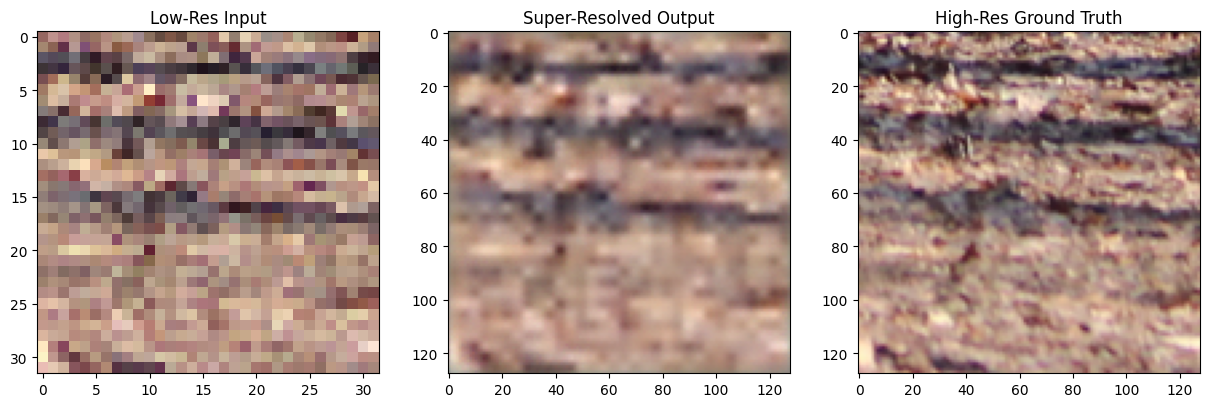

In [ ]:
# ✅ 1. Import Libraries
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# ✅ 2. Dataset Loader (Flickr2K)
class Flickr2KDataset(Dataset):
    def __init__(self, hr_size=128, scale=4):
        self.hr_path = "/content/Flickr2K/Flickr2K/Flickr2K_HR"
        self.hr_size = hr_size
        self.scale = scale
        self.image_files = sorted([f for f in os.listdir(self.hr_path) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.hr_path, self.image_files[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        top = np.random.randint(0, h - self.hr_size)
        left = np.random.randint(0, w - self.hr_size)
        hr_img = img[top:top+self.hr_size, left:left+self.hr_size]
        lr_img = cv2.resize(hr_img, (self.hr_size // self.scale, self.hr_size // self.scale), interpolation=cv2.INTER_CUBIC)

        hr_img = torch.tensor(hr_img / 127.5 - 1).permute(2, 0, 1).float()
        lr_img = torch.tensor(lr_img / 127.5 - 1).permute(2, 0, 1).float()
        return {'lr': lr_img, 'hr': hr_img}

# ✅ 3. Model Definition (Simplified Real-ESRGAN)
class ResidualDenseBlock(nn.Module):
    def __init__(self, channels=64, growth_channels=32):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(channels, growth_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(growth_channels, growth_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(growth_channels, growth_channels, 3, 1, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(growth_channels, channels, 3, 1, 1)
        )
    def forward(self, x):
        return x + self.layers(x) * 0.2

class RRDB(nn.Module):
    def __init__(self, channels=64):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(channels)
        self.rdb2 = ResidualDenseBlock(channels)
        self.rdb3 = ResidualDenseBlock(channels)
    def forward(self, x):
        return x + self.rdb3(self.rdb2(self.rdb1(x))) * 0.2

class RealESRGAN(nn.Module):
    def __init__(self, scale=4, num_rrdb=5):
        super().__init__()
        self.conv_first = nn.Conv2d(3, 64, 3, 1, 1)
        self.trunk = nn.Sequential(*[RRDB() for _ in range(num_rrdb)])
        self.trunk_conv = nn.Conv2d(64, 64, 3, 1, 1)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.LeakyReLU(0.2, True),
        ) if scale == 4 else nn.Identity()
        self.final = nn.Conv2d(64, 3, 3, 1, 1)
    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.trunk(fea))
        out = fea + trunk
        out = self.upsample(out)
        return self.final(out)

# ✅ 4. Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Flickr2KDataset()
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

model = RealESRGAN().to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5  # You can change this
save_path = "/content/real_esrgan_flickr2k.pth"

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr = batch['lr'].to(device)
        hr = batch['hr'].to(device)

        sr = model(lr)
        loss = criterion(sr, hr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

# ✅ 5. Save Model
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

# ✅ 6. Load Model
model.load_state_dict(torch.load(save_path))
model.eval()

# ✅ 7. Evaluation Metrics: PSNR & SSIM
def evaluate_metrics(model, dataset, num_samples=5):
    psnr_vals, ssim_vals = [], []
    with torch.no_grad():
        for i in range(num_samples):
            sample = dataset[i]
            lr = sample['lr'].unsqueeze(0).to(device)
            hr = sample['hr'].permute(1, 2, 0).numpy()
            sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()

            hr = ((hr + 1) * 127.5).astype(np.uint8)
            sr = ((sr + 1) * 127.5).astype(np.uint8)

            psnr_val = psnr_metric(hr, sr, data_range=255)
            ssim_val = ssim_metric(hr, sr, channel_axis=-1)

            psnr_vals.append(psnr_val)
            ssim_vals.append(ssim_val)

    print(f"\nPSNR: {np.mean(psnr_vals):.2f} dB")
    print(f"SSIM: {np.mean(ssim_vals):.4f}")

evaluate_metrics(model, dataset, num_samples=10)

# ✅ 8. Show Output
def show_sr_result(model, dataset, idx=0):
    with torch.no_grad():
        sample = dataset[idx]
        lr = sample['lr'].unsqueeze(0).to(device)
        sr = model(lr).squeeze(0).cpu().permute(1, 2, 0).numpy()
        hr = sample['hr'].permute(1, 2, 0).numpy()
        lr = sample['lr'].permute(1, 2, 0).numpy()

        sr = (sr + 1) * 127.5
        hr = (hr + 1) * 127.5
        lr = (lr + 1) * 127.5

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(lr.astype(np.uint8))
        plt.title("Low-Res Input")
        plt.subplot(1, 3, 2)
        plt.imshow(sr.astype(np.uint8))
        plt.title("Super-Resolved Output")
        plt.subplot(1, 3, 3)
        plt.imshow(hr.astype(np.uint8))
        plt.title("High-Res Ground Truth")
        plt.show()

show_sr_result(model, dataset, idx=0)
